In [44]:
import pandas as pd

In [45]:
# Load the data
# Dataset link: https://www.kaggle.com/uciml/sms-spam-collection-dataset

df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# Drop the columns that are not required
df.drop(columns={'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'}, inplace = True)

In [49]:
# Rename the columns
df.rename(columns= {'v1':'Class', 'v2':'SMS'}, inplace=True )
df.sample(5)

,Class,SMS
3476,ham,I got it before the new year cos yetunde said ...
3936,ham,"Yeah, in fact he just asked if we needed anyth..."
3002,ham,I will see in half an hour
1517,spam,Our brand new mobile music service is now live...
3574,ham,And do you have any one that can teach me how ...


In [50]:
# Convert the class labels to binary
df['Class'] = df['Class'].replace(['ham', 'spam'], [0, 1])

In [51]:
df.head(5)

,Class,SMS
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [52]:
df.groupby('Class').describe()

SMS                                                               
      count unique                                                top freq
Class                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [53]:
#drop duplicates
df = df.drop_duplicates(keep = 'first')

In [54]:
df.groupby('Class').describe()

SMS                                                               
      count unique                                                top freq
Class                                                                     
0      4516   4516  Go until jurong point, crazy.. Available only ...    1
1       653    653  Free entry in 2 a wkly comp to win FA Cup fina...    1

In [55]:
# Add a column for the length of the SMS
df['Length'] = df['SMS'].apply(len)
df.head(5)

<ipython-input-55-62d4ef8baa4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length'] = df['SMS'].apply(len)


,Class,SMS,Length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

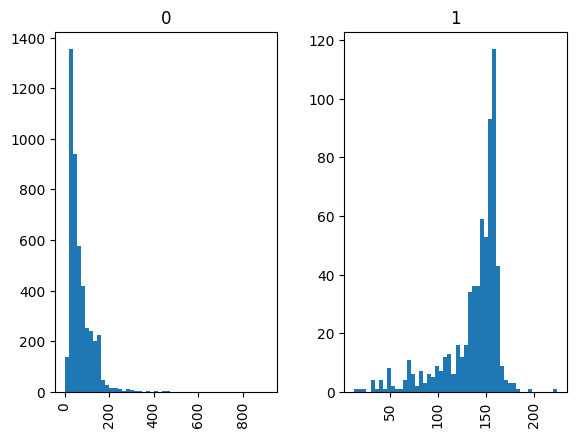

In [56]:
# Plot the length of the SMS; grouped by class  [spam (1) / ham(0)]
df.hist(column='Length', by='Class', bins=50)

In [57]:
sms = []
status = []

for index, row in df.iterrows():
    sms.append(row['SMS'])
    status.append(row['Class'])

In [58]:
from sklearn.model_selection import train_test_split

# Split the dataset into 80% train and 20% validation set
sms_train, sms_val, status_train, status_val = train_test_split(sms, status, test_size=0.2, random_state=42)

# Print the lengths of the train and validation sets
print("Train set length:", len(sms_train), len(status_train))
print("Validation set length:", len(sms_val), len(status_val))


Train set length: 4135 4135
Validation set length: 1034 1034


In [59]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

#Update the Vocabulary
tokenizer.fit_on_texts(sms_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(sms_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(sms_val)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(status_train)
testing_labels = np.array(status_val)


In [60]:
import tensorflow as tf

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                12544     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174129 (680.19 KB)
Trainable params: 174129 (680.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
NUM_EPOCHS = 10
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/10
130/130 [==============================] - 18s 105ms/step - loss: 0.3455 - accuracy: 0.8933 - val_loss: 0.1110 - val_accuracy: 0.9749
Epoch 2/10
130/130 [==============================] - 12s 94ms/step - loss: 0.0665 - accuracy: 0.9809 - val_loss: 0.0485 - val_accuracy: 0.9836
Epoch 3/10
130/130 [==============================] - 13s 96ms/step - loss: 0.0255 - accuracy: 0.9923 - val_loss: 0.0375 - val_accuracy: 0.9894
Epoch 4/10
130/130 [==============================] - 12s 94ms/step - loss: 0.0132 - accuracy: 0.9952 - val_loss: 0.0373 - val_accuracy: 0.9894
Epoch 5/10
130/130 [==============================] - 13s 97ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0413 - val_accuracy: 0.9874
Epoch 6/10
130/130 [==============================] - 12s 93ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0432 - val_accuracy: 0.9855
Epoch 7/10
130/130 [==============================] - 11s 86ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0492 - val_accuracy

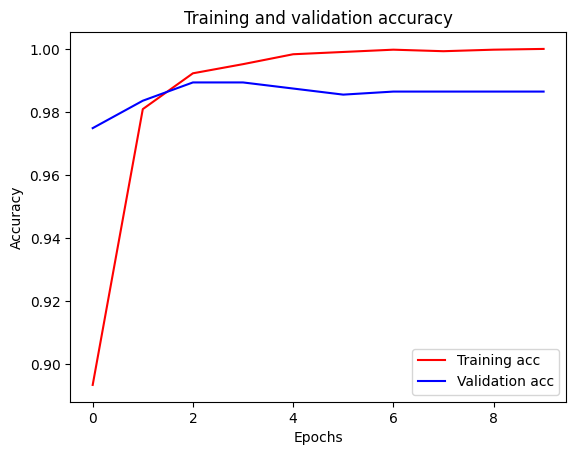

In [64]:
import matplotlib.pyplot as plt

# Get the accuracy values from the history dictionary
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']

# Get the number of epochs
epochs = range(len(acc))

# Plot the accuracy and validation accuracy curves
plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

# Add labels and title
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend and show the plot
plt.legend()
plt.show()

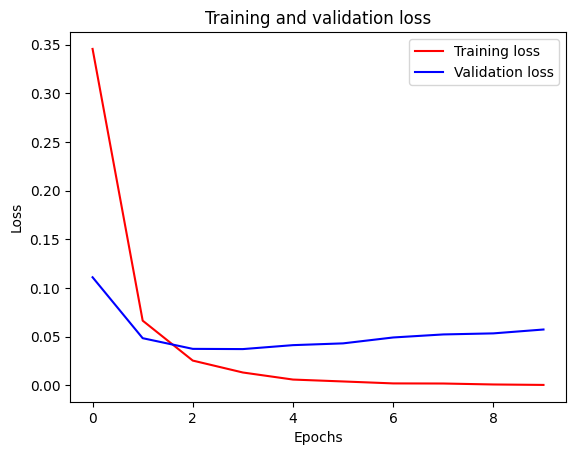

In [65]:
# prompt: plot same as accuracy as loss

# Get the loss values from the history dictionary
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Get the number of epochs
epochs = range(len(loss))

# Plot the loss and validation loss curves
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

# Add labels and title
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend and show the plot
plt.legend()
plt.show()


In [70]:
#predict first datat in the dataframe using the created mode

first_message = df['SMS'][0]

# Preprocess the message
first_message_sequence = tokenizer.texts_to_sequences([first_message])
first_message_padded = pad_sequences(first_message_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Predict the class of the first message
predicted_class = model_lstm.predict(first_message_padded)

# Print the predicted class
if predicted_class > 0.1:
    print("Predicted class for the first message: Spam")
else:
    print("Predicted class for the first message: Ham")



1/1 [==============================] - 0s 73ms/step
Predicted class for the first message: [[0.03875428]]


130/130 [==============================] - 3s 21ms/step


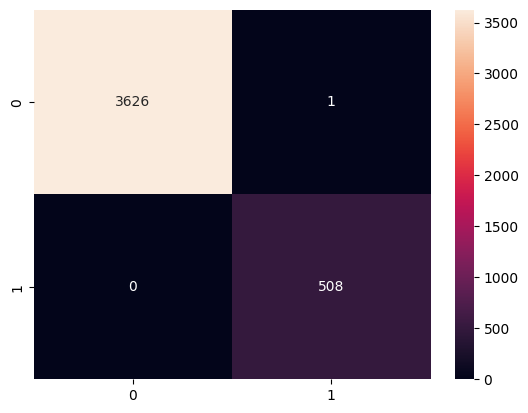

In [84]:
#confuction matrix as a heat map for training

import seaborn as sns

# Get the predictions for the validation set
predictions = model_lstm.predict(training_padded)

# Convert the predictions to binary values
binary_predictions = np.where(predictions > 0.1, 1, 0)

# Get the confusion matrix
confusion_matrix = tf.math.confusion_matrix(training_labels, binary_predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.show()


33/33 [==============================] - 1s 37ms/step


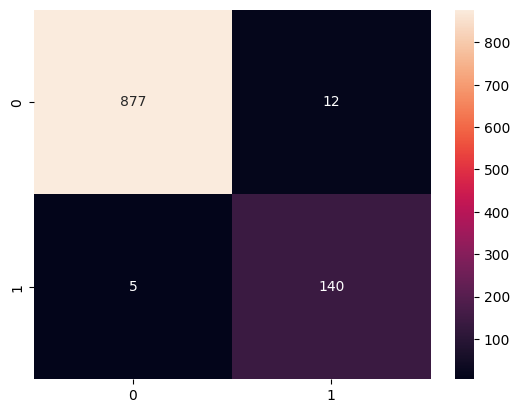

In [85]:
#confuction matrix as a heat map for testing

import seaborn as sns

# Get the predictions for the validation set
predictions = model_lstm.predict(testing_padded)

# Convert the predictions to binary values
binary_predictions = np.where(predictions > 0.1, 1, 0)

# Get the confusion matrix
confusion_matrix = tf.math.confusion_matrix(testing_labels, binary_predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.show()